### Parameters and Functions - Experiments and Plots

In [1]:
NBINS = [5,10,30,100]
drift_magnitudes = [0,0.05,0.4,0.75]

In [2]:
from numpy.random import Generator, PCG64
import pandas as pd
from scipy.stats import iqr

def generate_data(
    distribution: str = "normal", generator=None, drift_magnitude: float = 0, size: int = 100000
) -> pd.Series:
    if generator is None:
        generator = Generator(PCG64(12345))

    if distribution == "normal":
        sample = generator.standard_normal(size)
    elif distribution == "pareto":
        a,m = 7.,2.
        sample = (generator.pareto(a, size) + 1) * m
    elif distribution == "uniform":
        sample = generator.uniform(-5,5,size)
    else:
        raise ValueError("Distribution not found.")
    # offset = (sample.max() - sample.min()) * drift_magnitude
    offset = (iqr(sample)) * drift_magnitude
    drifted_sample = sample + offset
    return pd.Series(drifted_sample)

In [3]:
import pandas as pd
from numpy.random import Generator, PCG64
from scipy.stats import iqr

def generate_data(
    distribution: str = "normal", generator=None, drift_magnitude: float = 0, size: int = 100000
) -> pd.Series:
    if generator is None:
        generator = Generator(PCG64(12345))

    if distribution == "normal":
        sample = generator.standard_normal(size)
    elif distribution == "pareto":
        a,m = 7.,2.
        sample = (generator.pareto(a, size) + 1) * m
    elif distribution == "uniform":
        sample = generator.uniform(-5,5,size)
    else:
        raise ValueError("Distribution not found.")
    offset = (iqr(sample)) * drift_magnitude
    drifted_sample = sample + offset
    return pd.Series(drifted_sample)

In [8]:
import os
  
  
# checking if the directory demo_folder2 
# exist or not.
if not os.path.isdir("heltest"):
    
    # if the demo_folder2 directory is 
    # not present then create it.
    os.makedirs("heltest")

In [18]:
from whylogs.core.view.dataset_profile_view import DatasetProfileView
import pandas as pd
import whylogs as why
d = {}
df = pd.DataFrame(data=d)

db = why.log(df).profile().view()

whylogs was passed an empty pandas DataFrame so nothing to profile in this call.


In [22]:
target_col_view

NameError: name 'target_col_view' is not defined

In [24]:
from numpy.random import Generator, PCG64
import numpy as np
from scipy.spatial.distance import euclidean
import whylogs as why
import os
import pandas as pd
from whylogs.viz.utils.drift_calculations import _get_hellinger_distance

path = "profiles_hellinger"

def hellinger(x,y):
    return euclidean(np.sqrt(x), np.sqrt(y)) / np.sqrt(2)

def calculate_hellinger_ground_truth(ref,target,nbins=30):
    upper = max([ref.max(),target.max()])
    lower = min([ref.min(),target.min()])
    hist1, _ = np.histogram(ref,bins=nbins,range=(lower,upper))
    hist2, _ = np.histogram(target,bins=nbins,range=(lower,upper))

    ref_pmf = hist1/sum(hist1)
    target_pmf = hist2/sum(hist2)

    return hellinger(ref_pmf,target_pmf)


def run_hellinger_experiment(distribution="normal", drift_magnitude=0):
    
    size_list = [500, 1000, 5000, 10000, 50000]
    experiment_results = {}
    d = {}
    df = pd.DataFrame(data=d)
    target_grouped = why.log(df).profile().view()
    reference_grouped = why.log(df).profile().view()
    ref_views = {}
    target_views = {}
    for i_bin, nbins in enumerate(NBINS):
        stats_truths = []
        bars1 = []
        heights1 = []
        stats_means = []
        stats_ranges = []
        for sample_size in size_list:
            rng = Generator(PCG64(42))
            ref, target = pd.DataFrame(), pd.DataFrame()
            ref["col"] = generate_data(distribution=distribution, generator=rng, drift_magnitude=0, size=sample_size)
            target["col"] = generate_data(distribution=distribution, generator=rng, drift_magnitude=drift_magnitude, size=sample_size)


            ground_truth = calculate_hellinger_ground_truth(ref['col'],target['col'],nbins=nbins)
            errors = []
            stats_list = []
            for i in range(10):
                ref_profile = why.log(ref).profile()
                ref_view = ref_profile.view()

                target_profile = why.log(target).profile()
                target_view = target_profile.view()
                target_col_view = target_view._columns['col']
                ref_col_view = ref_view._columns['col']
                res = _get_hellinger_distance(target_view_column=target_col_view, reference_view_column=ref_col_view,nbins=nbins)
                stats = res['statistic']
                if i==0 and nbins==30:
                    col_name = f"{distribution}_size{sample_size}_drift{drift_magnitude}_hel{round(stats,7)}"
                    ref_views[col_name] = ref_col_view
                    target_views[col_name] = target_col_view
                # if i == 0:
                #     dist_path = os.path.join(path,distribution)
                #     if not os.path.isdir(dist_path):
                #         os.makedirs(dist_path)
                #     folder_name = f"size{sample_size}_drift{drift_magnitude}_hel{round(stats,7)}"
                #     complete_path = os.path.join(dist_path,folder_name)
                #     if not os.path.isdir(complete_path):
                #         os.makedirs(complete_path)
                #         why.write(ref_view,os.path.join(complete_path,"reference.bin"))
                #         why.write(target_view,os.path.join(complete_path,"target.bin"))

                error = abs(stats - ground_truth)
                errors.append(error)
                stats_list.append(stats)
            mean = sum(errors)/len(errors)
            mean_stats = sum(stats_list)/len(stats_list)

            
            range_stats = [abs(mean_stats-min(stats_list)),abs(mean_stats-max(stats_list))] 
            error = [abs(mean-min(errors)),abs(mean-max(errors))]

            stats_truths.append(ground_truth)
            bars1.append(mean)
            heights1.append(error)

            stats_means.append(mean_stats)
            stats_ranges.append(range_stats)

        y_err = [[x[0] for x in heights1],[x[1] for x in heights1]]
        stats_rg = [[x[0] for x in stats_ranges],[x[1] for x in stats_ranges]]

        experiment_results[nbins] = {}
        experiment_results[nbins]['bar'] = bars1
        experiment_results[nbins]['yerr'] = y_err
        experiment_results[nbins]['stats_means'] = stats_means
        experiment_results[nbins]['stats_ranges'] = stats_rg
        experiment_results[nbins]['stats_truths'] = stats_truths
        experiment_results[nbins]['label'] = "no. of bins={}".format(nbins)
        experiment_results[nbins]['distribution'] = distribution
    target_grouped._columns = target_views
    reference_grouped._columns = ref_views
    why.write(target_grouped,f"target_grouped_{distribution}.bin")
    why.write(reference_grouped,f"reference_grouped_{distribution}.bin")

    return experiment_results


def run_experiment_on_params(distribution="normal",magnitudes = drift_magnitudes):
    exps_results = {}

    for drift_magnitude in magnitudes:
        exps_results[drift_magnitude] = run_hellinger_experiment(distribution=distribution, drift_magnitude=drift_magnitude)

    return exps_results

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_buckets_experiment(quant_bars_per_drift):
    fig, axs = plt.subplots(2,2)
    fig.tight_layout(pad=1.0)
    barWidth = 0.17
    # this plots 4 subplots in a 2x2 matrix
    assert len(quant_bars_per_drift)==4
    for i,drift_magnitude in enumerate(quant_bars_per_drift):
        quant_bars = quant_bars_per_drift[drift_magnitude]
        x,y = int(i%2),int(i/2)


        for ix,key in enumerate(quant_bars):
            r1 = np.arange(len(quant_bars[key]['bar']))
            r2 = [x+ix*barWidth for x in r1]
            axs[x][y].bar(r2, quant_bars[key]['bar'], width = barWidth, edgecolor = 'black', yerr=quant_bars[key]['yerr'], label=quant_bars[key]['label'])
        
        # general layout
        axs[x][y].tick_params(axis='both', which='major', labelsize=6)
        axs[x][y].set_xticks([r+1.5*barWidth for r in range(len(quant_bars[key]['bar']))], ['1k', '5k', '10k','50k','100k'])
        axs[x][y].set_ylabel('error')
        if i==2:
            axs[x][y].legend(loc=1, prop={'size': 6})
        axs[x][y].set_xlabel('Drift Size:{}'.format(drift_magnitude))
        axs[x][y].set_ylim(bottom=0)
    fig.text(.5, -0.05, "Hellinger distance mean abs. error according to sample size for {} distribution and varying drift magnitudes. K=1024".format(quant_bars[key]['distribution']), ha='center',fontsize=10)


    plt.show()

In [6]:
def plot_pvalues(quant_bars_per_drift):
    fig, axs = plt.subplots(2,2)
    fig.tight_layout(pad=1.0)
    nbins = 30
    for i,key in enumerate(quant_bars_per_drift): 
        quant_bars = quant_bars_per_drift[key]
        x,y = int(i%2),int(i/2)
        stats_means = quant_bars[nbins]['stats_means']
        stats_range = quant_bars[nbins]['stats_ranges']
        stats_truth = quant_bars[nbins]['stats_truths']


        r1 = np.arange(len(stats_means))
        # r2 = [x+ix*barWidth for x in r1]
        axs[x][y].set_xticks([r for r in range(len(quant_bars[nbins]['bar']))], ['1k', '5k', '10k','50k','100k'])
        axs[x][y].errorbar(r1, stats_means, yerr=stats_range, capsize=7, label="whylogs")
        axs[x][y].set_ylabel('distance')
        axs[x][y].plot(r1,stats_truth, label="scipy")
        if i==2:
            axs[x][y].legend(loc=1, prop={'size': 12})
        axs[x][y].set_xlabel('Drift Size:{}'.format(key))


    fig.text(.5, -0.05, "Hellinger Distance comparison between whylogs and scipy. K=1024, {} bins, {} distribution".format(nbins,quant_bars[nbins]['distribution']),  ha='center',fontsize=10)
    plt.show()

In [5]:
from statistics import mean, stdev
from numpy.random import default_rng
from numpy.random import Generator, PCG64
import numpy as np
from typing import Tuple
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_drift(distribution="normal", magnitudes = [0,0.01,0.05, 0.1], sample_size = 100000):

    rng = Generator(PCG64(42))
    fig, axs = plt.subplots(2,2)
    fig.tight_layout(pad=1.0)
    for ix,drift_magnitude in enumerate(magnitudes):
        x,y = int(ix%2),int(ix/2)

        df = pd.DataFrame()

        df["ref"] = generate_data(distribution=distribution, generator=rng, drift_magnitude=0, size=sample_size)
        df["target"] = generate_data(distribution=distribution, generator=rng, drift_magnitude=drift_magnitude, size=sample_size)



        # set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above)
        sns.set(style="darkgrid")

        sns.histplot(ax=axs[x][y],data=df, x="ref", color="skyblue", label="ref", kde=False)
        sns.histplot(ax=axs[x][y],data=df, x="target", color="red", label="target", kde=False)
        if ix==2:
            axs[x][y].legend(loc=0, prop={'size': 12})
        axs[x][y].set_xlabel('Drift Size:{}'.format(drift_magnitude))

    fig.text(.5, -0.05, "Artificial drift injection for varying drift magnitudes for {} distribution. Number of samples: {}".format(distribution,sample_size),  ha='center',fontsize=10)
    plt.show()


# Normal Distribution

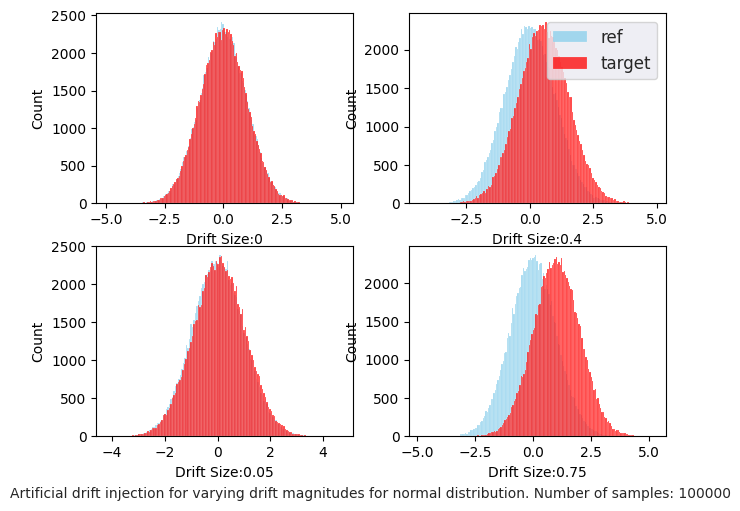

In [6]:
plot_drift(distribution="normal", magnitudes=drift_magnitudes)

In [25]:
exp_results = run_experiment_on_params(distribution="uniform",magnitudes=[0,0.05,0.4,0.75])

whylogs was passed an empty pandas DataFrame so nothing to profile in this call.


hello


KeyboardInterrupt: 

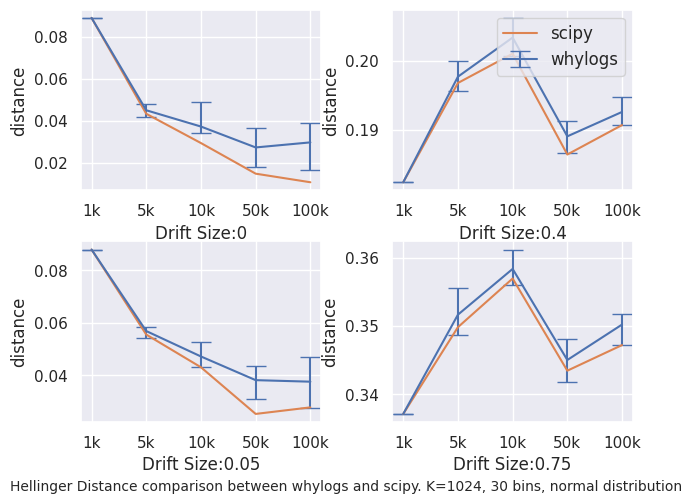

In [10]:
plot_pvalues(exp_results)

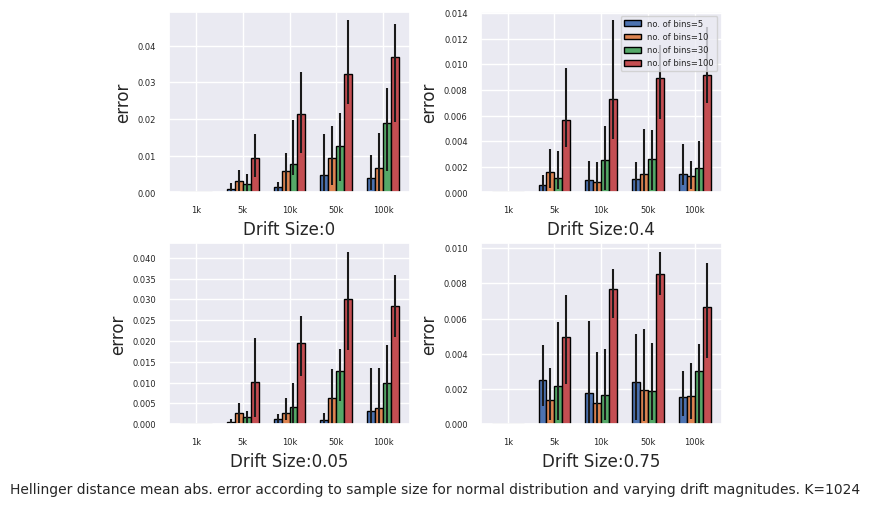

In [11]:
plot_buckets_experiment(exp_results)

# Pareto Distribution

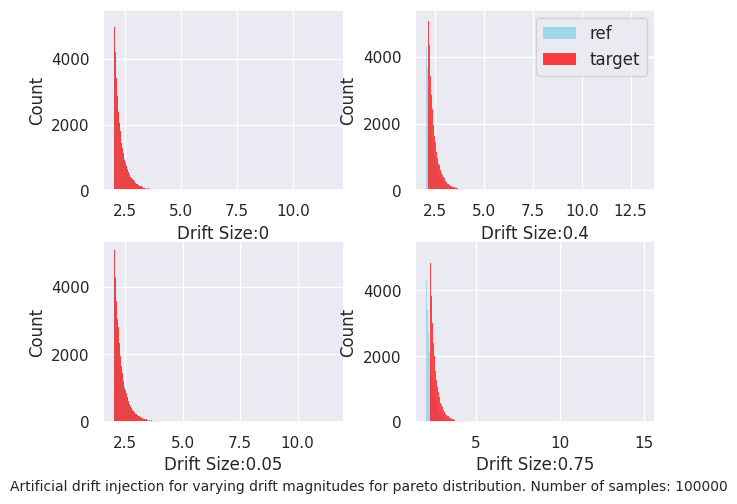

In [12]:
plot_drift(distribution="pareto", magnitudes=drift_magnitudes)

In [13]:
exp_results = run_experiment_on_params(distribution="pareto",magnitudes=[0,0.05,0.4,0.75])

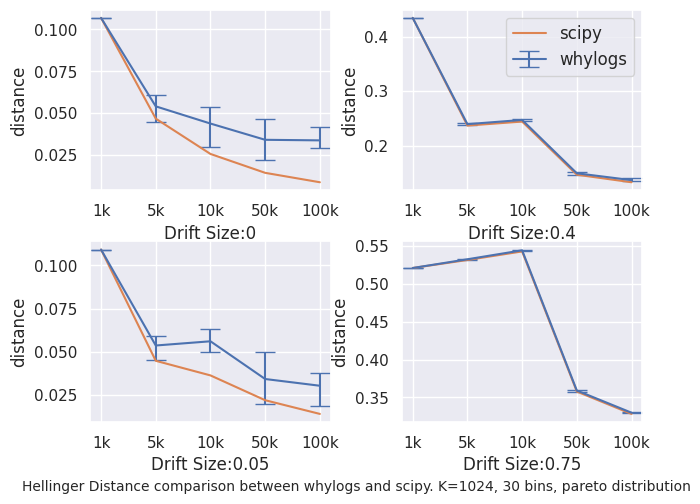

In [14]:
plot_pvalues(exp_results)

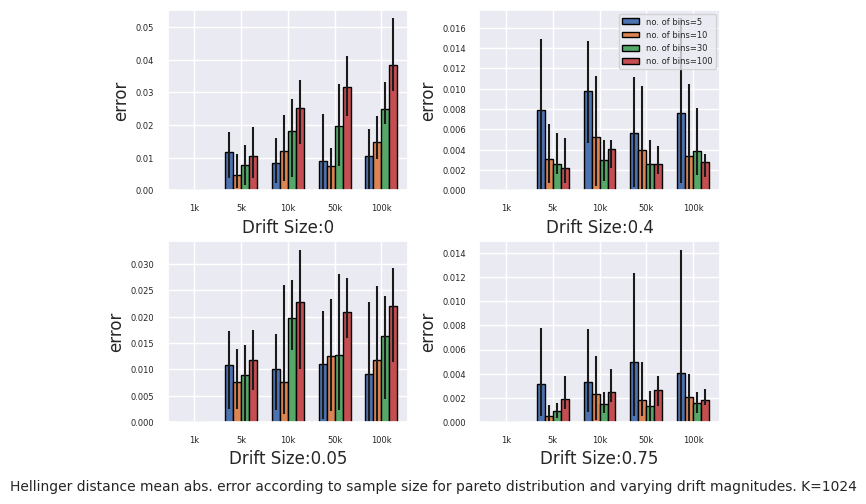

In [15]:
plot_buckets_experiment(exp_results)

# Uniform Distribution

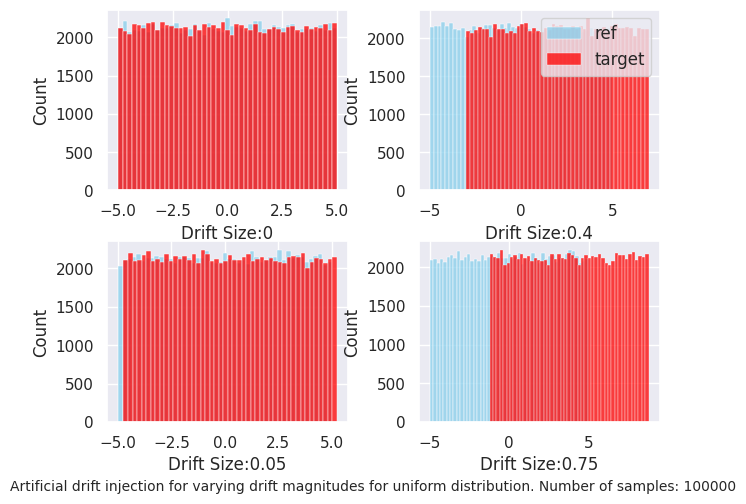

In [16]:
plot_drift(distribution="uniform", magnitudes=drift_magnitudes)

In [17]:
exp_results = run_experiment_on_params(distribution="uniform",magnitudes=[0,0.05,0.4,0.75])

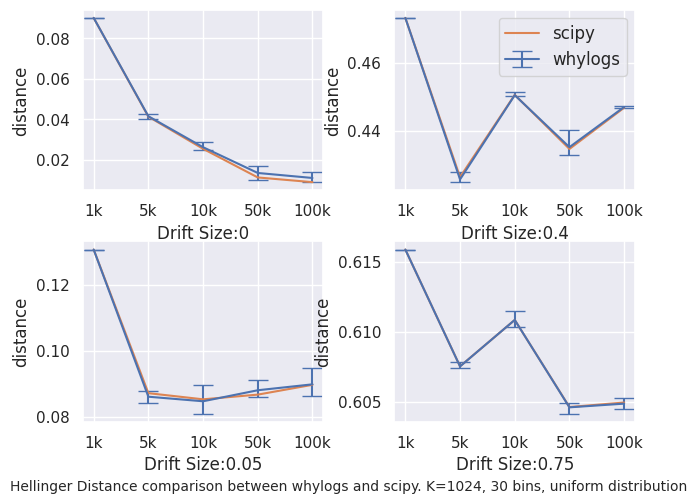

In [18]:
plot_pvalues(exp_results)

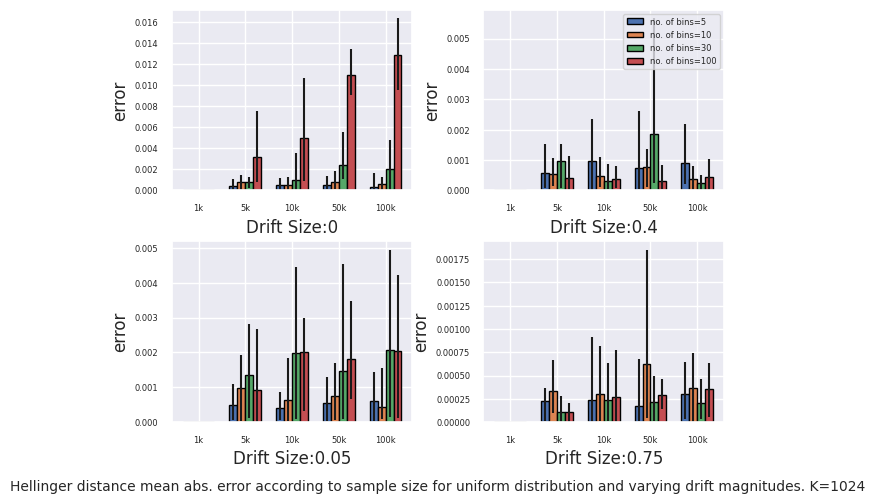

In [19]:
plot_buckets_experiment(exp_results)

# Profiling vs. Sampling

## Plots and Experiments - Defining Functions

In [20]:
from whylogs.core.resolvers import Resolver
from whylogs.core.datatypes import DataType, Fractional, Integral
from typing import Dict, List, TypedDict
from whylogs.core.metrics import StandardMetric
from whylogs.core.metrics.metrics import Metric
import whylogs as why
from whylogs.core import DatasetSchema
from whylogs.core import MetricConfig
import io
import pandas as pd


class DataFrameSize(TypedDict):
    sample_frac: float
    number_samples: int
    number_bytes: int


class MyCustomResolver(Resolver):
    """Resolver that assigns DistributionMetric to every column (which is ok because we only have one numerical column)."""

    def resolve(self, name: str, why_type: DataType, column_schema) -> Dict[str, Metric]:
        metrics: List[StandardMetric] = [StandardMetric.distribution]

        result: Dict[str, Metric] = {}
        for m in metrics:
            result[m.name] = m.zero(column_schema.cfg)
        return result

def get_parquet_size(df: pd.DataFrame, frac) -> int:
    res = DataFrameSize()
    with io.BytesIO() as buffer:
        df_sampled = df.sample(frac=frac)
        df_sampled.to_parquet(buffer)
        number_bytes = buffer.tell()
        sample_frac = frac
        number_samples = len(df_sampled)
        return DataFrameSize(sample_frac=sample_frac,number_bytes=number_bytes,number_samples=number_samples)

In [21]:
import numpy as np
from numpy.random import Generator, PCG64
import pandas as pd

def get_kll_size_map(kll_list:list):
    """
    This is just to find the proper number of samples and size in bytes to match sizes between profiles and sampled dataframes.
    Distribution type does not affect significantly the output.
    """
    rng = Generator(PCG64(42))
    distribution="normal"
    sample_size = 100000
    drift_magnitude = 0
    ref, target = pd.DataFrame(), pd.DataFrame()
    ref["col"] = generate_data(distribution=distribution, generator=rng, drift_magnitude=0, size=sample_size)
    kllSizeMap = {}
    for kll_val in kll_list:
        ref_view = why.log(ref, schema=DatasetSchema(default_configs=MetricConfig(kll_k_large=kll_val),resolvers=MyCustomResolver())).profile().view()
        ref_size = len(ref_view.serialize())
        closest_sample = DataFrameSize()
        distance = 10000000
        # closest_sample['distance'] = 1000000
        for frac in list(np.linspace(0.0001,0.2,200)):
            sample_size = get_parquet_size(ref,frac=frac)
            if abs(dist:=ref_size-sample_size["number_bytes"]) < distance:
                closest_sample = sample_size
                distance = dist 
        # print("Closest sample for kll = {} is: {}".format(kll_val,closest_sample))
        kllSizeMap[kll_val] = closest_sample
    return kllSizeMap

kll_list = [256,512,1024,2048,4096]
kllSizeMap = get_kll_size_map(kll_list=kll_list)

kllSizeMap

{256: {'sample_frac': 0.00311356783919598,
  'number_bytes': 6936,
  'number_samples': 311},
 512: {'sample_frac': 0.00612713567839196,
  'number_bytes': 11548,
  'number_samples': 613},
 1024: {'sample_frac': 0.013158793969849246,
  'number_bytes': 22429,
  'number_samples': 1316},
 2048: {'sample_frac': 0.026217587939698493,
  'number_bytes': 43048,
  'number_samples': 2622},
 4096: {'sample_frac': 0.05133065326633166,
  'number_bytes': 83332,
  'number_samples': 5133}}

In [22]:
from scipy import stats
from scipy.special import kl_div
from whylogs.viz.utils.drift_calculations import calculate_drift_values

def run_kll_hellinger_experiment(distribution="normal", magnitudes = drift_magnitudes, kllSizeMap:dict = {}):
    nbins = 100
    kll_list = [int(key) for key in kllSizeMap]
    sample_size = 100000
    kll_bars = {}
    for drift_magnitude in magnitudes:
        rng = Generator(PCG64(42))
        kll_bars[drift_magnitude] = {}
        ref, target = pd.DataFrame(), pd.DataFrame()
        ref["col"] = generate_data(distribution=distribution, generator=rng, drift_magnitude=0, size=sample_size)
        target["col"] = generate_data(distribution=distribution, generator=rng, drift_magnitude=drift_magnitude, size=sample_size)
        for kll_val in kll_list:
            kll_bars[drift_magnitude][kll_val] = {}
            ground_truth = calculate_hellinger_ground_truth(ref['col'],target['col'],nbins=nbins)
            profiled_stats_list = []
            sampled_stats_list = []
            for i in range(10):
                ref_profile = why.log(ref).profile()
                ref_view = ref_profile.view()

                target_profile = why.log(target).profile()
                target_view = target_profile.view()
                target_col_view = target_view._columns['col']
                ref_col_view = ref_view._columns['col']
                res = _get_hellinger_distance(target_view_column=target_col_view, reference_view_column=ref_col_view,nbins=nbins)
                profiled_stats = res['statistic']

                ref_sampled = ref.sample(frac=kllSizeMap[kll_val]['sample_frac'])
                target_sampled = target.sample(frac=kllSizeMap[kll_val]['sample_frac'])

                sampled_stats = calculate_hellinger_ground_truth(ref_sampled['col'],target_sampled['col'],nbins=nbins)

                profiled_stats_list.append(profiled_stats)
                sampled_stats_list.append(sampled_stats)

            size_bytes = kllSizeMap[kll_val]['number_bytes']
            size_kb = int(size_bytes/1000)
            profile_errors = [abs(pv-ground_truth) for pv in profiled_stats_list]
            sample_errors = [abs(pv-ground_truth) for pv in sampled_stats_list]

            profile_mean = sum(profile_errors)/len(profile_errors)
            sample_mean = sum(sample_errors)/len(sample_errors)

            range_profile_errors = [abs(profile_mean-min(profile_errors)),abs(profile_mean-max(profile_errors))] 
            range_sample_errors = [abs(sample_mean-min(sample_errors)),abs(sample_mean-max(sample_errors))] 


            kll_bars[drift_magnitude][kll_val]['size_kb'] = size_kb
            kll_bars[drift_magnitude][kll_val]['profile_bars'] = profile_mean
            kll_bars[drift_magnitude][kll_val]['sample_bars'] = sample_mean
            kll_bars[drift_magnitude][kll_val]['profile_yerr'] = range_profile_errors
            kll_bars[drift_magnitude][kll_val]['sample_yerr'] = range_sample_errors
            kll_bars[drift_magnitude][kll_val]['distribution'] = distribution
    return kll_bars


In [23]:
from turtle import color
import numpy as np
import matplotlib.pyplot as plt

def plot_kll_experiment(bars_per_kll_per_drift, include_sampling=True):
    fig, axs = plt.subplots(2,2)
    fig.tight_layout(pad=1.0)
    barWidth = 0.17
    for i,drift_magnitude in enumerate(bars_per_kll_per_drift):
        x,y = int(i%2),int(i/2)
        bars_per_kll = bars_per_kll_per_drift[drift_magnitude] 
        profile_bars = [bars_per_kll[key]['profile_bars'] for key in bars_per_kll]
        profile_error = [[bars_per_kll[key]['profile_yerr'][0] for key in bars_per_kll],[bars_per_kll[key]['profile_yerr'][1] for key in bars_per_kll]]

        size_kb = ["{} KB".format(bars_per_kll[key]['size_kb']) for key in bars_per_kll]


        r1 = np.arange(len(profile_bars))
        r2 = [x + barWidth for x in r1]

        if include_sampling:
            sample_bars = [bars_per_kll[key]['sample_bars'] for key in bars_per_kll]
            sample_error = [[bars_per_kll[key]['sample_yerr'][0] for key in bars_per_kll],[bars_per_kll[key]['sample_yerr'][1] for key in bars_per_kll]]
            axs[x][y].bar(r2, sample_bars, color= 'tab:blue',edgecolor='black', yerr = sample_error, width=barWidth,label='Sampled')
        

        axs[x][y].tick_params(axis='both', which='major', labelsize=6)
        axs[x][y].set_xticks([r+1*barWidth for r in range(len(profile_bars))], size_kb)
        axs[x][y].bar(r1, profile_bars, color='tab:orange',edgecolor='black', yerr = profile_error, width=barWidth,label='Profiled')
        axs[x][y].set_xlabel('Drift Size:{}'.format(drift_magnitude))
        axs[x][y].set_ylabel('error')

        if i==2:
            axs[x][y].legend(loc=1)
    first_key = list(bars_per_kll.keys())[0]
    if include_sampling:
        fig.text(.5, -0.05, "KS pvalue mean abs. error comparison between profiling and sampling. {} distribution".format(bars_per_kll[first_key]['distribution']),  ha='center',fontsize=10)
    else:
        fig.text(.5, -0.05, "KS pvalue mean abs. error for profiling. {} distribution".format(bars_per_kll[first_key]['distribution']),  ha='center',fontsize=10)
    plt.show()

## Normal Distribution

In [24]:
kll_bars = run_kll_hellinger_experiment(distribution="normal",magnitudes=drift_magnitudes, kllSizeMap=kllSizeMap)

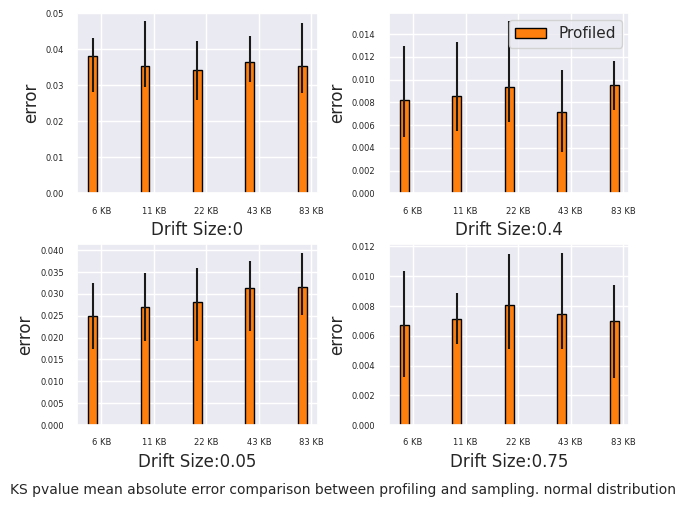

In [25]:
plot_kll_experiment(kll_bars, include_sampling=False)

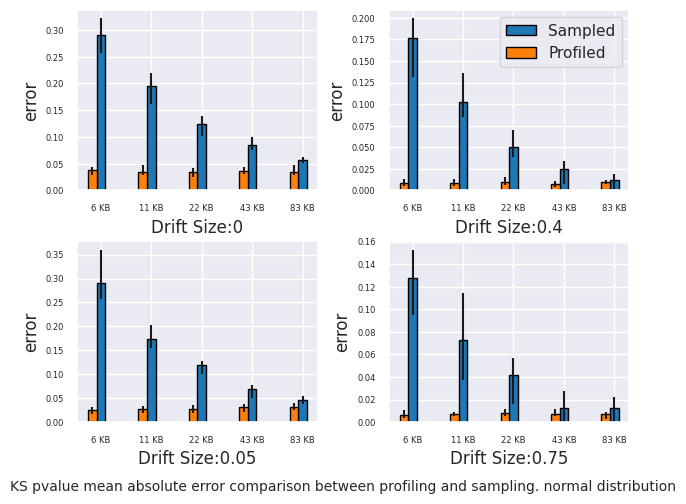

In [26]:
plot_kll_experiment(kll_bars)

## Pareto Distribution

In [27]:
kll_bars = run_kll_hellinger_experiment(distribution="pareto",magnitudes=drift_magnitudes, kllSizeMap=kllSizeMap)

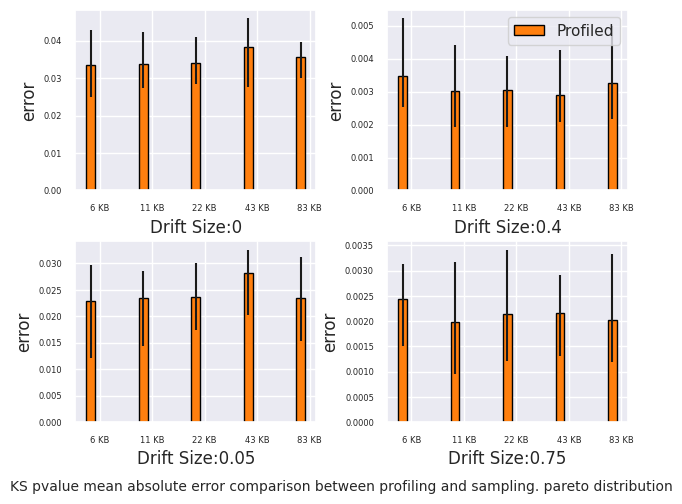

In [28]:
plot_kll_experiment(kll_bars, include_sampling=False)

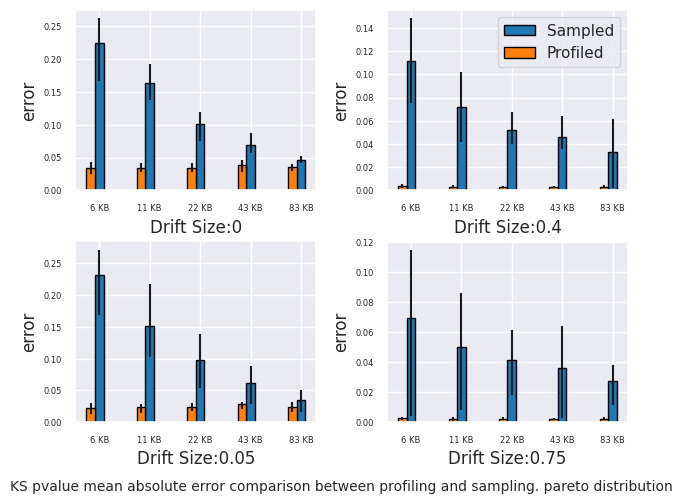

In [29]:
plot_kll_experiment(kll_bars)

## Uniform Distribution

In [30]:
kll_bars = run_kll_hellinger_experiment(distribution="uniform",magnitudes=drift_magnitudes, kllSizeMap=kllSizeMap)

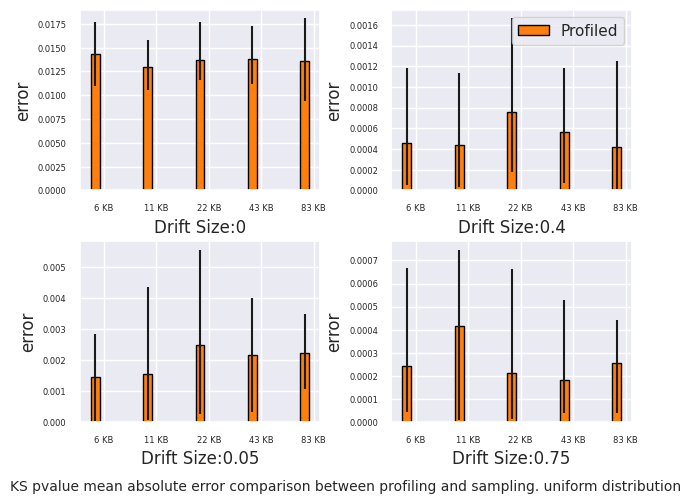

In [31]:
plot_kll_experiment(kll_bars,include_sampling=False)

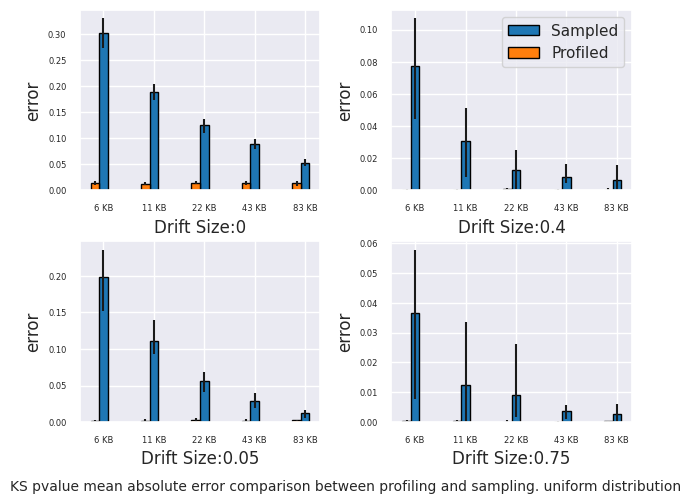

In [32]:
plot_kll_experiment(kll_bars)